In [120]:
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
import pydotplus 
import statistics 
import pandas as pd
import os
from datetime import date
from tqdm.notebook import tqdm
from IPython.display import Image  
#import scikitplot as skplt
import wittgenstein as lw
from imblearn.over_sampling import SMOTE

from scipy.stats.stats import pearsonr
from scipy.spatial.distance import pdist,  squareform
import scipy.stats as stats
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay # For Model evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import re

/var/folders/jf/2klxw_5j40b99lw0dpk1tt5w0000gn/T/ipykernel_81654/509576357.py:16: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


#### Load the dataset

In [121]:
users = pd.read_csv('new_users.csv', lineterminator='\n', index_col=0)
#tweets = pd.read_csv('new_tweets.csv', lineterminator='\n', index_col=0)

In [122]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 0 to 10457
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            10458 non-null  int64  
 1   name               10457 non-null  object 
 2   lang               10458 non-null  object 
 3   bot                10458 non-null  int64  
 4   statuses_count     10458 non-null  int64  
 5   count              10458 non-null  int64  
 6   retweet_received   10458 non-null  int64  
 7   reply_received     10458 non-null  int64  
 8   favorite_received  10458 non-null  int64  
 9   hashtag_used       10458 non-null  int64  
 10  urls_used          10458 non-null  int64  
 11  mentions_used      10458 non-null  int64  
 12  favorite_avg       10458 non-null  float64
 13  retweet_avg        10458 non-null  float64
 14  reply_avg          10458 non-null  float64
 15  urls_avg           10458 non-null  float64
 16  mentions_avg       104

### Utility Functions

In [123]:
def discretize_data(dataset, variables): #mapping categorical into numerical
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

#### Filtering Dataset Attribute to classification

In [124]:
columns = ['lang']
data = discretize_data(users, columns)
data

,user_id,name,lang,bot,statuses_count,count,retweet_received,reply_received,favorite_received,hashtag_used,...,activity_period,Bot_Entropy,sub_year,sub_month,sub_day,retweet_max,reply_max,favorite_max,interaction_count,lang_num
0,2353593986,Lamonica Raborn,en,1,132,132,5,0,5,13,...,5,0.001426,2019,2,22,1.0,0.0,1.0,9,4
1,2358850842,Lourie Botton,en,0,122,122,3,0,6,4,...,5,NaN,2019,2,26,1.0,0.0,1.0,9,4
2,466124818,Carletto Focia,it,1,1439,1439,1190,0,259,107,...,30,0.001426,2017,1,18,364.0,0.0,11.0,238,11
3,2571493866,MBK Ebook,en,0,7085,3656,62,0,226,479,...,4,NaN,2019,6,18,3.0,0.0,2.0,246,4
4,2199062688,Qq,en,0,7406,2081,31810,0,1260,54,...,19,NaN,2018,11,19,390.0,0.0,12.0,1643,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10453,1901595415,Prity Baleja,en,0,418,418,1601,0,89,566,...,4,NaN,2018,9,26,303.0,0.0,5.0,143,4
10454,2911861962,Madrid Lae Maika .,en,0,1126,1120,19585,0,66,245,...,4,NaN,2019,11,29,391.0,0.0,3.0,249,4
10455,1378532629,Clau Sato,en,0,3024,2088,7391,0,449,268,...,31,NaN,2018,4,27,395.0,0.0,4.0,441,4
10456,2383025796,Minnie Guadagno,en,1,105,105,7,0,9,1,...,4,0.001426,2019,3,13,2.0,0.0,1.0,11,4


In [125]:
#drop the categorical variables since we don't need them anymore 
data.drop(columns=['lang', 'name', 'Bot_Entropy'], axis=1,inplace=True)

### Classification

In [126]:
label = data.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(data, label, stratify=label, test_size=0.30)

#### Decision Tree Classification

In [127]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, 
                                  min_samples_split=3, min_samples_leaf=4)
dt = dt.fit(train_set, train_label)

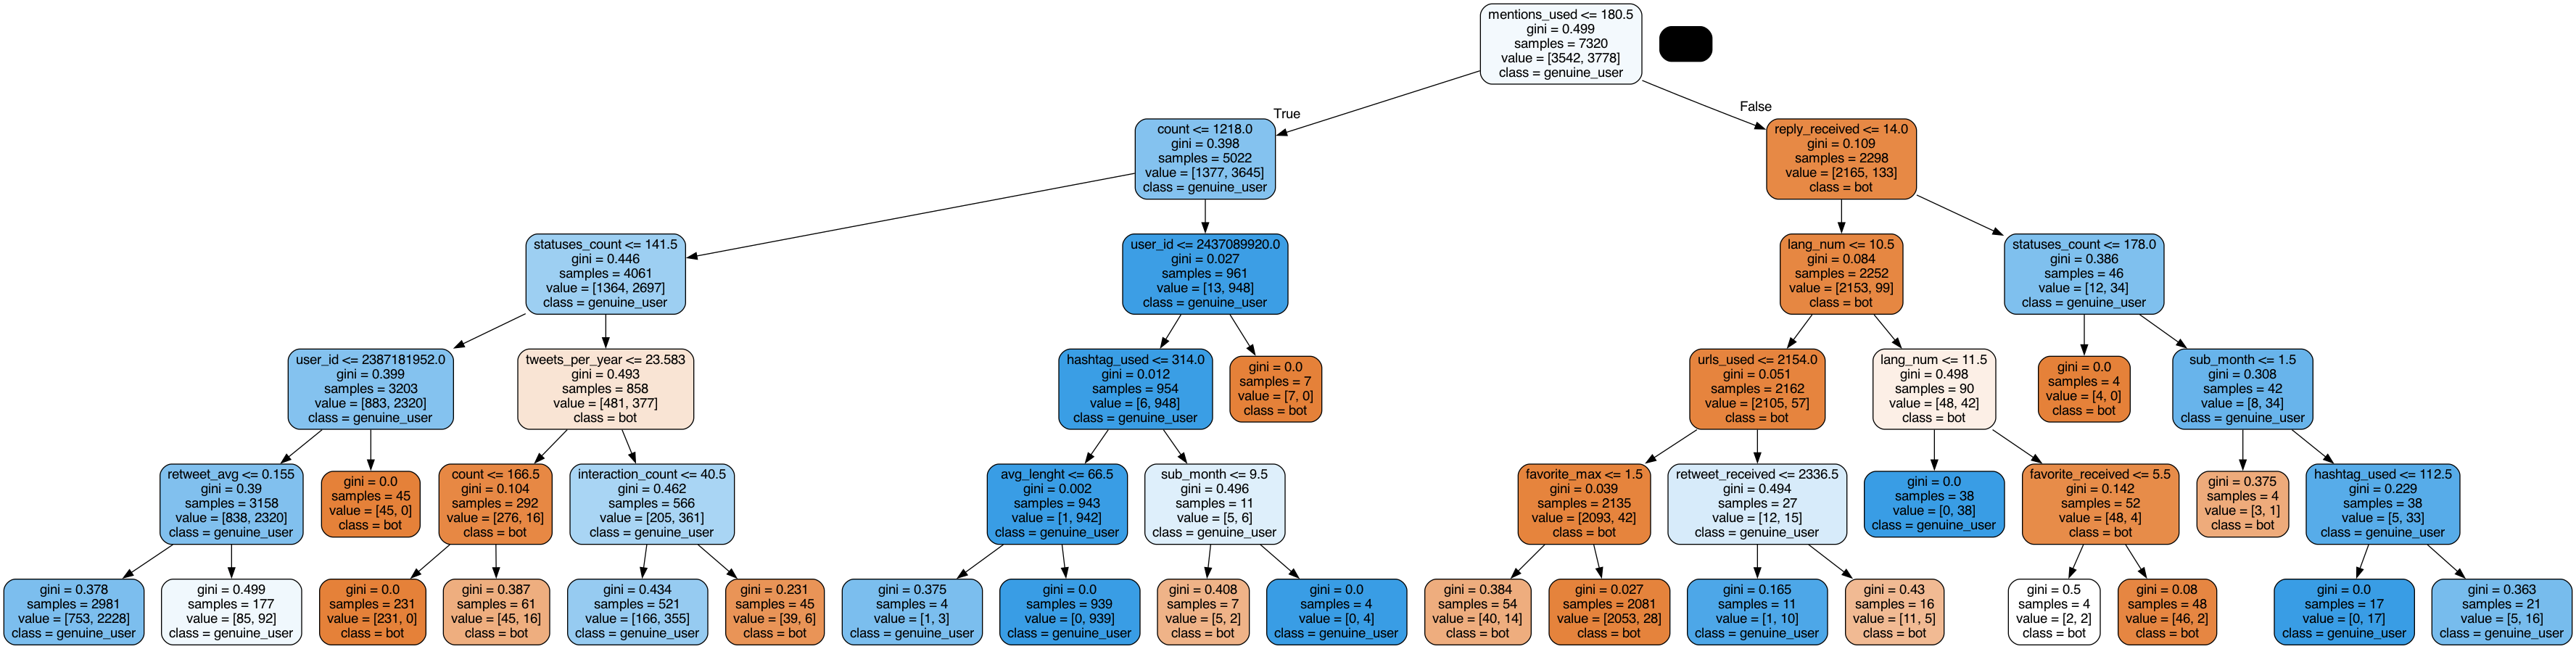

In [128]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['bot', 'genuine_user'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [129]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

##### Evaluation of Decision Tree Classification

In [130]:
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.8515027322404372
Accuracy test set  0.8448056086679414
Precision train set  0.875179278259734
Recall train set  0.8515027322404372
F1 score train set  0.8483886961967069
Support train set  (array([0.97084772, 0.78548695]), array([0.71456804, 0.97988354]), array([0.82322329, 0.8719821 ]), array([3542, 3778]))


In [131]:
print(classification_report(test_label, 
                            test_pred_dt, 
                            target_names=['bot', 'genuine user']))

              precision    recall  f1-score   support

         bot       0.97      0.70      0.81      1518
genuine user       0.78      0.98      0.87      1620

    accuracy                           0.84      3138
   macro avg       0.87      0.84      0.84      3138
weighted avg       0.87      0.84      0.84      3138



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


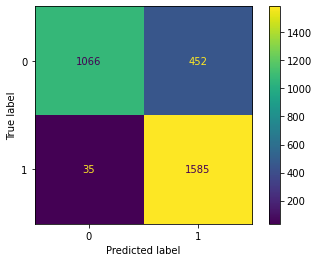

In [132]:
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

#### Naive Bayes

##### Evaluation of Naive Bayes Classification